In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pickle
import zipfile
from datetime import datetime
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import xgboost
from rank_bm25 import BM25
from scipy.sparse import hstack
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge,Lasso,ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\SAPEKSHA\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
train_data = zipfile.ZipFile('G:/Applied_AI/case_study_1/train.csv.zip')
train_data = pd.read_csv(train_data.open('train.csv'),encoding = "ISO-8859-1")
print('train_data',train_data.shape)

attribute_data = zipfile.ZipFile('G:/Applied_AI/case_study_1/attributes.csv.zip')
attribute_data = pd.read_csv(attribute_data.open('attributes.csv'),encoding = "ISO-8859-1")
print('Attribute_data',attribute_data.shape)

description_data = zipfile.ZipFile('G:/Applied_AI/case_study_1/product_descriptions.csv.zip')
description_data = pd.read_csv(description_data.open('product_descriptions.csv'),encoding = "ISO-8859-1")
print('description_data',description_data.shape)

# test_data = zipfile.ZipFile('G:/Applied_AI/case_study_1/test.csv.zip')
# test_data = pd.read_csv(test_data.open('test.csv'),encoding = "ISO-8859-1")
# print('test_data',test_data.shape)

train_data (74067, 5)
Attribute_data (2044803, 3)
description_data (124428, 2)


In [3]:
data = pd.read_pickle('G:/Final Data_1/clean_dataset_.pkl')

In [4]:
print(data.shape)
data.head()

(74067, 8)


,id,product_uid,product_title,search_term,relevance,brand,combine_feature_,product_description
0,2,100001,simpson strong tie 12 gaug angl,angl bracket,3.00,simpson strong tie,0 bullet 01 versatil connector variou 90 1 bul...,angl make joint stronger also provid consist s...
1,3,100001,simpson strong tie 12 gaug angl,l bracket,2.50,simpson strong tie,0 bullet 01 versatil connector variou 90 1 bul...,angl make joint stronger also provid consist s...
2,9,100002,behr premium textur deckov 1 gallon sc 141 tug...,deck over,3.00,behr premium textur deckov,15 applic method brush roller spray 16 assembl...,behr premium textur deckov innov solid color c...
3,16,100005,delta vero 1 handl shower faucet trim kit chro...,rain shower head,2.33,delta,50 bath faucet type combo tub shower 51 built ...,updat bathroom delta vero singl handl shower f...
4,17,100005,delta vero 1 handl shower faucet trim kit chro...,shower onli faucet,2.67,delta,50 bath faucet type combo tub shower 51 built ...,updat bathroom delta vero singl handl shower f...


In [5]:
def common_word(feature_1,feature_2):
    common_word=[]
    words,count = feature_1.split(),0
    for i in words:
        set_1 = set(feature_1.split())
        set_2 = set(feature_2.split())
        common_ = set_1.intersection(set_2)
        common_ = ' '.join(common_)
        common_word.append(common_)
        return ''.join([i for i in common_word])
    

   

In [6]:
data['product_info'] = data['product_title'] + ' \t ' + data['product_description'] + ' \t ' + data['brand']+ ' \t ' + data['search_term']


In [7]:
# Train Data
data['common_word_ST'] = data['product_info'].map(lambda x: common_word(x.split('\t')[3],x.split('\t')[0]))
data['common_word_SD'] = data['product_info'].map(lambda x: common_word(x.split('\t')[3],x.split('\t')[1]))
data['common_word_SB'] = data['product_info'].map(lambda x: common_word(x.split('\t')[3],x.split('\t')[2]))

# Train Data
# num common words
data['num_common_word_ST'] = data['common_word_ST'].apply(lambda x: len(x.split()))
data['num_common_word_SD'] = data['common_word_SD'].apply(lambda x: len(x.split()))
data['num_common_word_SB'] = data['common_word_SB'].apply(lambda x: len(x.split()))


In [8]:
data.isnull().sum()

id                     0
product_uid            0
product_title          0
search_term            0
relevance              0
brand                  0
combine_feature_       0
product_description    0
product_info           0
common_word_ST         0
common_word_SD         0
common_word_SB         0
num_common_word_ST     0
num_common_word_SD     0
num_common_word_SB     0
dtype: int64

In [9]:
def cosine_similarity(feature_1,feature_2):
    f_1 = set(feature_1.split())
    f_2 = set(feature_2.split())
    num = len(f_1.intersection(f_2))
    deno = np.sqrt(len(f_1)) * np.sqrt(len(f_2))
    
    if deno == 0:
        return 0
    else:
        return num/deno
    

In [10]:
# cosine distance
data['cosine_ST'] = data.apply(lambda x: cosine_similarity(x['search_term'],x['product_title']),axis=1)
data['cosine_SB'] = data.apply(lambda x: cosine_similarity(x['search_term'],x['brand']),axis=1)
data['cosine_SD'] = data.apply(lambda x: cosine_similarity(x['search_term'],x['product_description']),axis=1)


In [11]:
def jaccard_coefficient(feature_1,feature_2):
    f_1 = set(feature_1.split())
    f_2 = set(feature_2.split())
    num = len(f_1.intersection(f_2))
    deno = len(f_1 | f_2)
    if deno == 0:
        return 0
    else:
        return num/deno

In [12]:
# Jaccard Coefficient
data['jaccard_ST'] = data.apply(lambda x: jaccard_coefficient(x['search_term'],x['product_title']),axis=1)
data['jaccard_SB'] = data.apply(lambda x: jaccard_coefficient(x['search_term'],x['brand']),axis=1)
data['jaccard_SD'] = data.apply(lambda x: jaccard_coefficient(x['search_term'],x['product_description']),axis=1)


In [13]:
# Train Data
data['len_product_title'] = data['product_title'].str.split().apply(len)
data['len_search_term'] = data['search_term'].str.split().apply(len)
data['len_of_brand'] = data['brand'].str.split().apply(len)
data['len_product_description'] = data['product_description'].str.split().apply(len)
data['len_combine_feature_'] = data['combine_feature_'].str.split().apply(len)


In [14]:
data['ratio_title_search'] = data['len_product_title'] / data['len_search_term']
data['ratio_descrip_search'] = data['len_product_description'] / data['len_search_term']
data['ratio_common_ST_to_search_term'] = data['num_common_word_ST'] / data['len_search_term']
data['ratio_common_SD_to_search_term'] = data['num_common_word_SD'] / data['len_search_term']
data['ratio_common_SB_to_search_term'] = data['num_common_word_SB'] / data['len_search_term']


In [15]:
from rank_bm25 import BM25

def bm25_params(corpus):
    vectorizer = TfidfVectorizer()
    vectorizer.fit(corpus)
    idf_name_value = dict(zip(vectorizer.get_feature_names(),(list(vectorizer.idf_))))
    length = [len(i.split()) for i in corpus]
    avgdl = np.average(length)                      
    param = {'idf_name_value':idf_name_value,'avgdl':avgdl,'len_corpus':len(corpus)}
    return param

def bm25_scores(param,text,query,k=1.5,b=0.75):
    idf_name_value = param['idf_name_value']
    avgdl = param['avgdl']
    N=param['len_corpus']
    score = 0
    
    for word in query.split():
        mod_d = len(text.split())  # len of document
        n_tf = text.count(word)   # no of times query occur in document
        
        if word in idf_name_value.keys():  # check if word present in document
            idf_score = idf_name_value[word]
        else:
            idf_score = np.log(1+N)+1    #  idf for words not in document    
        score_ = idf_score * (n_tf*(k+1) / (n_tf + k * (1-b + b * (mod_d / avgdl))))
        score+=score_
    return score

In [16]:
param_title = bm25_params(data['product_title'])
data['BM25_ST']  = data.apply(lambda x : bm25_scores(param_title,x['product_title'],x['search_term']),axis=1)
#---------------------------------search to brand------------------------------------
param_brand = bm25_params(data['brand'])
data['BM25_SB']  = data.apply(lambda x : bm25_scores(param_brand,x['brand'],x['search_term']),axis=1)
#---------------------------------search to description------------------------------------
param_desc = bm25_params(data['product_description'])
data['BM25_SD']  = data.apply(lambda x : bm25_scores(param_brand,x['product_description'],x['search_term']),axis=1)

In [17]:
data.head(3)

,id,product_uid,product_title,search_term,relevance,brand,combine_feature_,product_description,product_info,common_word_ST,...,len_product_description,len_combine_feature_,ratio_title_search,ratio_descrip_search,ratio_common_ST_to_search_term,ratio_common_SD_to_search_term,ratio_common_SB_to_search_term,BM25_ST,BM25_SB,BM25_SD
0,2,100001,simpson strong tie 12 gaug angl,angl bracket,3.0,simpson strong tie,0 bullet 01 versatil connector variou 90 1 bul...,angl make joint stronger also provid consist s...,simpson strong tie 12 gaug angl \t angl make j...,angl,...,96,100,3.0,48.0,0.5,0.5,0.0,8.073802,0.00000,1.242767
1,3,100001,simpson strong tie 12 gaug angl,l bracket,2.5,simpson strong tie,0 bullet 01 versatil connector variou 90 1 bul...,angl make joint stronger also provid consist s...,simpson strong tie 12 gaug angl \t angl make j...,,...,96,100,3.0,48.0,0.0,0.0,0.0,15.772143,0.00000,5.634293
2,9,100002,behr premium textur deckov 1 gallon sc 141 tug...,deck over,3.0,behr premium textur deckov,15 applic method brush roller spray 16 assembl...,behr premium textur deckov innov solid color c...,behr premium textur deckov 1 gallon sc 141 tug...,,...,122,197,6.0,61.0,0.0,0.5,0.0,5.696886,5.32376,0.977943


In [18]:
data = data.sort_values('relevance', ascending=False).drop_duplicates('product_uid').sort_index()

In [19]:
print(data.shape)
data.head(3)

(54667, 34)


,id,product_uid,product_title,search_term,relevance,brand,combine_feature_,product_description,product_info,common_word_ST,...,len_product_description,len_combine_feature_,ratio_title_search,ratio_descrip_search,ratio_common_ST_to_search_term,ratio_common_SD_to_search_term,ratio_common_SB_to_search_term,BM25_ST,BM25_SB,BM25_SD
0,2,100001,simpson strong tie 12 gaug angl,angl bracket,3.00,simpson strong tie,0 bullet 01 versatil connector variou 90 1 bul...,angl make joint stronger also provid consist s...,simpson strong tie 12 gaug angl \t angl make j...,angl,...,96,100,3.000000,48.000000,0.500000,0.500000,0.0,8.073802,0.00000,1.242767
2,9,100002,behr premium textur deckov 1 gallon sc 141 tug...,deck over,3.00,behr premium textur deckov,15 applic method brush roller spray 16 assembl...,behr premium textur deckov innov solid color c...,behr premium textur deckov 1 gallon sc 141 tug...,,...,122,197,6.000000,61.000000,0.000000,0.500000,0.0,5.696886,5.32376,0.977943
4,17,100005,delta vero 1 handl shower faucet trim kit chro...,shower onli faucet,2.67,delta,50 bath faucet type combo tub shower 51 built ...,updat bathroom delta vero singl handl shower f...,delta vero 1 handl shower faucet trim kit chro...,faucet shower,...,70,138,3.666667,23.333333,0.666667,0.666667,0.0,9.759462,0.00000,0.772914


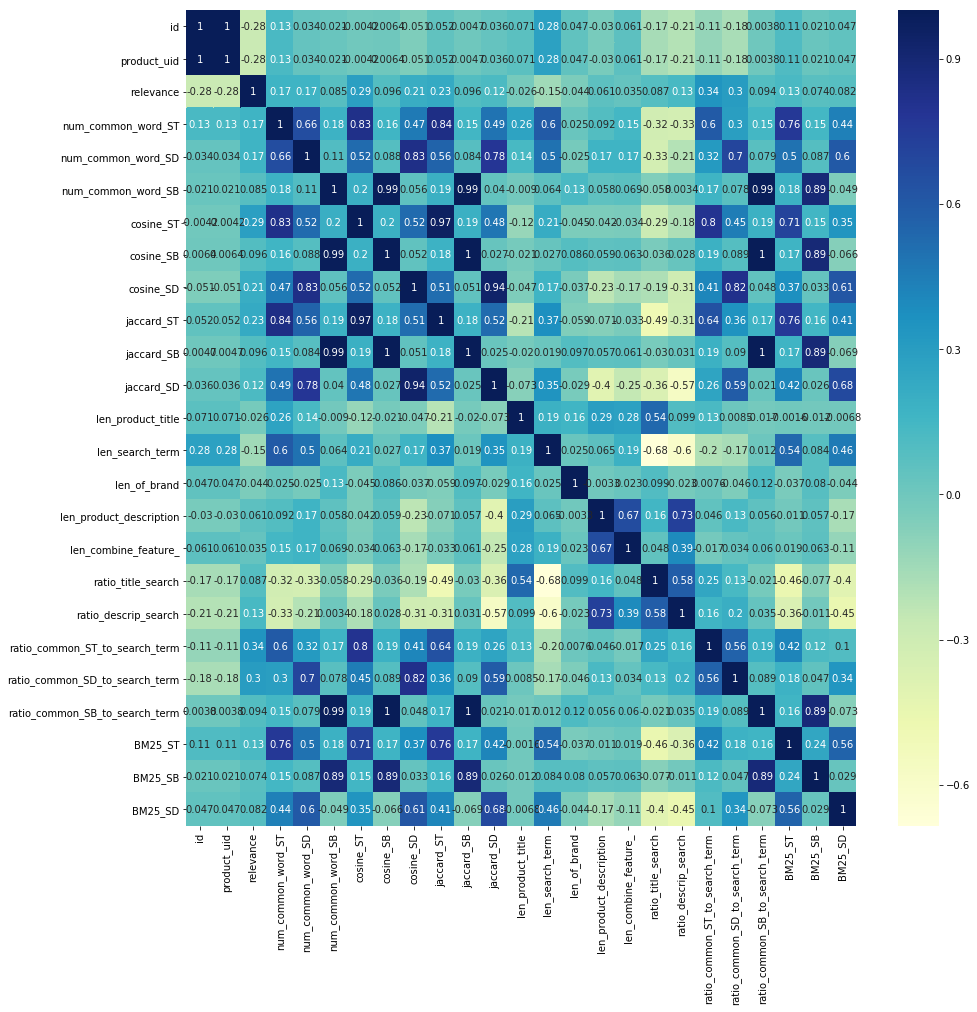

In [20]:
# plotting correlation heatmap
features = data.columns
plt.figure(figsize=(15,15))
corr_df = data[features].corr(method='spearman')
sns.heatmap(corr_df, cmap="YlGnBu", annot=True)  
plt.show()

In [21]:
corr_df.abs()['relevance'].sort_values(ascending=False)

relevance                         1.000000
ratio_common_ST_to_search_term    0.342897
ratio_common_SD_to_search_term    0.304463
cosine_ST                         0.288777
product_uid                       0.279825
id                                0.279825
jaccard_ST                        0.228282
cosine_SD                         0.209679
num_common_word_SD                0.167742
num_common_word_ST                0.167150
len_search_term                   0.147446
ratio_descrip_search              0.133267
BM25_ST                           0.131133
jaccard_SD                        0.118964
cosine_SB                         0.095537
jaccard_SB                        0.095501
ratio_common_SB_to_search_term    0.093751
ratio_title_search                0.087440
num_common_word_SB                0.084797
BM25_SD                           0.082289
BM25_SB                           0.074448
len_product_description           0.061207
len_of_brand                      0.044342
len_combine

In [22]:
train_df,test_df = train_test_split(data,test_size=0.3,random_state=42,shuffle=True,stratify=data['relevance'])

In [23]:
print('train_df :',train_df.shape)
print('test_df :',test_df.shape)

train_df : (38266, 34)
test_df : (16401, 34)


In [24]:
vectorizer_title=TfidfVectorizer(min_df=1,ngram_range=(1,4),max_features=5000)
X_train_title = vectorizer_title.fit_transform(train_df['product_title'].values)

X_test_title =vectorizer_title.transform(test_df['product_title'].values)
print(X_train_title.shape)
print(X_test_title.shape)

(38266, 5000)
(16401, 5000)


In [25]:
vectorizer_search=TfidfVectorizer(min_df=1,ngram_range=(1,4),max_features=5000)
X_train_search =  vectorizer_search.fit_transform(train_df['search_term'].values)

X_test_search =vectorizer_search.transform(test_df['search_term'].values)
print(X_train_search.shape)
print(X_test_search.shape)

(38266, 5000)
(16401, 5000)


In [26]:
vectorizer_brand=TfidfVectorizer(min_df=1,ngram_range=(1,4),max_features=5000)
X_train_brand = vectorizer_brand.fit_transform(train_df['brand'].values)

X_test_brand =vectorizer_brand.transform(test_df['brand'].values)
print(X_train_brand.shape)
print(X_test_brand.shape)

(38266, 5000)
(16401, 5000)


In [27]:
vectorizer_des=TfidfVectorizer(min_df=1,ngram_range=(1,4),max_features=5000)
X_train_des = vectorizer_des.fit_transform(train_df['product_description'].values)

X_test_des =vectorizer_des.transform(test_df['product_description'].values)
print(X_train_des.shape)
print(X_test_des.shape)

(38266, 5000)
(16401, 5000)


In [28]:
vectorizer_combine_ft=TfidfVectorizer(min_df=1,ngram_range=(1,4),max_features=5000)
X_train_combine_ft = vectorizer_combine_ft.fit_transform(train_df['combine_feature_'].values)

X_test_combine_ft =vectorizer_combine_ft.transform(test_df['combine_feature_'].values)
print(X_train_combine_ft.shape)
print(X_test_combine_ft.shape)

(38266, 5000)
(16401, 5000)


In [29]:
vectorizer_common_ST=TfidfVectorizer(min_df=1,ngram_range=(1,4),max_features=5000)
X_train_common_ST = vectorizer_common_ST.fit_transform(train_df['common_word_ST'].values)

X_test_common_ST =vectorizer_common_ST.transform(test_df['common_word_ST'].values)
print(X_train_common_ST.shape)
print(X_test_common_ST.shape)

(38266, 5000)
(16401, 5000)


In [30]:
vectorizer_common_SD=TfidfVectorizer(min_df=1,ngram_range=(1,4),max_features=5000)
X_train_common_SD = vectorizer_common_SD.fit_transform(train_df['common_word_SD'].values)

X_test_common_SD =vectorizer_common_SD.transform(test_df['common_word_SD'].values)
print(X_train_common_SD.shape)
print(X_test_common_SD.shape)

(38266, 5000)
(16401, 5000)


In [31]:
vectorizer_common_SB=TfidfVectorizer(min_df=1,ngram_range=(1,4),max_features=5000)
X_train_common_SB = vectorizer_common_SB.fit_transform(train_df['common_word_SB'].values)

X_test_common_SB =vectorizer_common_SB.transform(test_df['common_word_SB'].values)
print(X_train_common_SB.shape)
print(X_test_common_SB.shape)

(38266, 1106)
(16401, 1106)


In [32]:
normalizer_ft1=Normalizer()
X_train_len_title = normalizer_ft1.fit_transform(train_df["len_product_title"].values.reshape(-1,1))

X_test_len_title =normalizer_ft1.transform(test_df["len_product_title"].values.reshape(-1,1))
print(X_train_len_title.shape)
print(X_test_len_title.shape)

(38266, 1)
(16401, 1)


In [33]:
normalizer_ft2=Normalizer()
X_train_len_search_term = normalizer_ft2.fit_transform(train_df["len_search_term"].values.reshape(-1,1))

X_test_len_search_term =normalizer_ft2.transform(test_df["len_search_term"].values.reshape(-1,1))

print(X_train_len_search_term.shape)
print(X_test_len_search_term.shape)

(38266, 1)
(16401, 1)


In [34]:
normalizer_ft3=Normalizer()
X_train_len_brand = normalizer_ft3.fit_transform(train_df["len_of_brand"].values.reshape(-1,1))

X_test_len_brand =normalizer_ft3.transform(test_df["len_of_brand"].values.reshape(-1,1))

print(X_train_len_brand.shape)
print(X_test_len_brand.shape)

(38266, 1)
(16401, 1)


In [35]:
normalizer_ft4=Normalizer()
X_train_len_des = normalizer_ft4.fit_transform(train_df["len_product_description"].values.reshape(-1,1))

X_test_len_des =normalizer_ft4.transform(test_df["len_product_description"].values.reshape(-1,1))

print(X_train_len_des.shape)
print(X_test_len_des.shape)

(38266, 1)
(16401, 1)


In [36]:
normalizer_ft5=Normalizer()
X_train_len_combine_ft = normalizer_ft5.fit_transform(train_df["len_combine_feature_"].values.reshape(-1,1))

X_test_len_combine_ft =normalizer_ft5.transform(test_df["len_combine_feature_"].values.reshape(-1,1))

print(X_train_len_combine_ft.shape)
print(X_test_len_combine_ft.shape)

(38266, 1)
(16401, 1)


In [37]:
normalizer_ft6=Normalizer()
X_train_num_SB = normalizer_ft6.fit_transform(train_df["num_common_word_SB"].values.reshape(-1,1))

X_test_num_SB =normalizer_ft6.transform(test_df["num_common_word_SB"].values.reshape(-1,1))

print(X_train_num_SB.shape)
print(X_test_num_SB.shape)

(38266, 1)
(16401, 1)


In [38]:
normalizer_ft7=Normalizer()
X_train_num_SD = normalizer_ft7.fit_transform(train_df["num_common_word_SD"].values.reshape(-1,1))

X_test_num_SD =normalizer_ft7.transform(test_df["num_common_word_SD"].values.reshape(-1,1))

print(X_train_num_SD.shape)
print(X_test_num_SD.shape)

(38266, 1)
(16401, 1)


In [39]:
normalizer_ft8=Normalizer()
X_train_num_ST = normalizer_ft8.fit_transform(train_df["num_common_word_ST"].values.reshape(-1,1))

X_test_num_ST =normalizer_ft8.transform(test_df["num_common_word_ST"].values.reshape(-1,1))

print(X_train_num_ST.shape)
print(X_test_num_ST.shape)

(38266, 1)
(16401, 1)


In [40]:
normalizer_ft9=Normalizer()
X_train_bm25_st = normalizer_ft9.fit_transform(train_df["BM25_ST"].values.reshape(-1,1))

X_test_bm25_st =normalizer_ft9.transform(test_df["BM25_ST"].values.reshape(-1,1))

print(X_train_bm25_st.shape)
print(X_test_bm25_st.shape)

(38266, 1)
(16401, 1)


In [41]:
normalizer_ft10=Normalizer()
X_train_bm25_sb = normalizer_ft10.fit_transform(train_df["BM25_SB"].values.reshape(-1,1))

X_test_bm25_sb =normalizer_ft10.transform(test_df["BM25_SB"].values.reshape(-1,1))

print(X_train_bm25_sb.shape)
print(X_test_bm25_sb.shape)

(38266, 1)
(16401, 1)


In [42]:
normalizer_ft11=Normalizer()
X_train_bm25_sd = normalizer_ft11.fit_transform(train_df["BM25_SD"].values.reshape(-1,1))

X_test_bm25_sd =normalizer_ft11.transform(test_df["BM25_SD"].values.reshape(-1,1))

print(X_train_bm25_sd.shape)
print(X_test_bm25_sd.shape)

(38266, 1)
(16401, 1)


In [43]:
X_train_cosine_ST = train_df['cosine_ST'].values.reshape(-1,1)
X_test_cosine_ST = test_df['cosine_ST'].values.reshape(-1,1)
print('X_train_cosine_ST',X_train_cosine_ST.shape)
print('X_test_cosine_ST',X_test_cosine_ST.shape)

X_train_cosine_ST (38266, 1)
X_test_cosine_ST (16401, 1)


In [44]:
X_train_cosine_SD = train_df['cosine_SD'].values.reshape(-1,1)
X_test_cosine_SD = test_df['cosine_SD'].values.reshape(-1,1)
print('X_train_cosine_SD',X_train_cosine_SD.shape)
print('X_test_cosine_SD',X_test_cosine_SD.shape)

X_train_cosine_SD (38266, 1)
X_test_cosine_SD (16401, 1)


In [45]:
X_train_cosine_SB = train_df['cosine_SB'].values.reshape(-1,1)
X_test_cosine_SB = test_df['cosine_SB'].values.reshape(-1,1)

In [46]:
X_train_jaccard_ST = train_df['jaccard_ST'].values.reshape(-1,1)
X_test_jaccard_ST = test_df['jaccard_ST'].values.reshape(-1,1)

In [47]:
X_train_jaccard_SD = train_df['jaccard_SD'].values.reshape(-1,1)
X_test_jaccard_SD = test_df['jaccard_SD'].values.reshape(-1,1)

In [48]:
X_train_jaccard_SB = train_df['jaccard_SB'].values.reshape(-1,1)
X_test_jaccard_SB = test_df['jaccard_SB'].values.reshape(-1,1)

In [49]:
X_train_ratio_title_search = train_df['ratio_title_search'].values.reshape(-1,1)
X_test_ratio_title_search = test_df['ratio_title_search'].values.reshape(-1,1)

In [50]:
X_train_ratio_desc_search = train_df['ratio_descrip_search'].values.reshape(-1,1)
X_test_ratio_desc_search = test_df['ratio_descrip_search'].values.reshape(-1,1)

In [51]:
X_train_ratio_common_ST_search = train_df['ratio_common_ST_to_search_term'].values.reshape(-1,1)
X_test_ratio_common_ST_search = test_df['ratio_common_ST_to_search_term'].values.reshape(-1,1)

In [52]:
X_train_ratio_common_SD_search = train_df['ratio_common_SD_to_search_term'].values.reshape(-1,1)
X_test_ratio_common_SD_search = test_df['ratio_common_SD_to_search_term'].values.reshape(-1,1)

In [53]:
X_train_ratio_common_SB_search = train_df['ratio_common_SB_to_search_term'].values.reshape(-1,1)
X_test_ratio_common_SB_search = test_df['ratio_common_SB_to_search_term'].values.reshape(-1,1)

### Save Data to local system

In [ ]:
with open('G:/Final Data_1/clean_train_df.pkl','wb') as f:
    pickle.dump(train_df,f)

In [ ]:
with open('G:/Final Data_1/clean_test_df.pkl','wb') as f:
    pickle.dump(test_df,f)

In [ ]:
with open('G:/Final Data_1/Features/title.pkl','wb') as f:
    pickle.dump(vectorizer_title,f)

with open('G:/Final Data_1/Features/search.pkl','wb') as f:
    pickle.dump(vectorizer_search,f)

with open('G:/Final Data_1/Features/brand.pkl','wb') as f:
    pickle.dump(vectorizer_brand,f)
    
with open('G:/Final Data_1/Features/description.pkl','wb') as f:
    pickle.dump(vectorizer_des,f)
    
with open('G:/Final Data_1/Features/combine_feature_.pkl','wb') as f:
    pickle.dump(vectorizer_combine_ft,f)
    
with open('G:/Final Data_1/Features/common_word_ST.pkl','wb') as f:
    pickle.dump(vectorizer_common_ST,f)
    
with open('G:/Final Data_1/Features/common_word_SD.pkl','wb') as f:
    pickle.dump(vectorizer_common_SD,f)
    
with open('G:/Final Data_1/Features/common_word_SB.pkl','wb') as f:
    pickle.dump(vectorizer_common_SB,f)
    
with open('G:/Final Data_1/Features/len_product_title.pkl','wb') as f:
    pickle.dump(normalizer_ft1,f)
    
with open('G:/Final Data_1/Features/len_search_term.pkl','wb') as f:
    pickle.dump(normalizer_ft2,f)
    
with open('G:/Final Data_1/Features/len_of_brand.pkl','wb') as f:
    pickle.dump(normalizer_ft3,f)
    
with open('G:/Final Data_1/Features/len_product_description.pkl','wb') as f:
    pickle.dump(normalizer_ft4,f)
    
with open('G:/Final Data_1/Features/len_combine_feature_.pkl','wb') as f:
    pickle.dump(normalizer_ft5,f)
    
with open('G:/Final Data_1/Features/num_common_word_SB.pkl','wb') as f:
    pickle.dump(normalizer_ft6,f)
    
with open('G:/Final Data_1/Features/num_common_word_SD.pkl','wb') as f:
    pickle.dump(normalizer_ft7,f)

    
with open('G:/Final Data_1/Features/num_common_word_ST.pkl','wb') as f:
    pickle.dump(normalizer_ft8,f)

    
with open('G:/Final Data_1/Features/BM25_ST.pkl','wb') as f:
    pickle.dump(normalizer_ft9,f)

with open('G:/Final Data_1/Features/BM25_SB.pkl','wb') as f:
    pickle.dump(normalizer_ft10,f)

with open('G:/Final Data_1/Features/BM25_SD.pkl','wb') as f:
    pickle.dump(normalizer_ft11,f)
    